# Making Predictions

## Combining Data

In [ ]:
import pandas as pd
import yfinance as yf


#Economic Data
series_ids = {
    'GDP': 'GDP',
    'Federal Funds': 'FEDFUNDS',
    'Unemployment Rate': 'UNRATE',
    'Consumer Price Index (CPI)': 'CPIAUCSL',
    'Producer Price Index (PPI)': 'PPIACO'
}
start_date = '2023-01-01'
end_date = '2023-12-15'

data = {}
for series_name, series_id in series_ids.items():
    data[series_name] = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)

economic_data = pd.DataFrame(data)

# datetime index
economic_data.index = pd.to_datetime(economic_data.index)

# SPY Data
spy_data = yf.download('SPY', start=start_date, end=end_date)

# Use'Close' price of SPY
spy_data = spy_data[['Close']]

# Combine the economic data and SPY data
combined_data = economic_data.join(spy_data, how='outer')

combined_data['GDP'] = combined_data['GDP'].fillna(method='ffill')
combined_data['Federal Funds'] = combined_data['Federal Funds'].fillna(method='ffill')
combined_data['Unemployment Rate'] = combined_data['Unemployment Rate'].fillna(method='ffill')
combined_data['Consumer Price Index (CPI)'] = combined_data['Consumer Price Index (CPI)'].fillna(method='ffill')
combined_data['Producer Price Index (PPI)'] = combined_data['Producer Price Index (PPI)'].fillna(method='ffill')
combined_data = combined_data.dropna(subset=['Close'])

# Print
combined_data

[*********************100%%**********************]  1 of 1 completed


,GDP,Federal Funds,Unemployment Rate,Consumer Price Index (CPI),Producer Price Index (PPI),Close
2023-01-03,26813.601,4.33,3.4,300.536,260.227,380.820007
2023-01-04,26813.601,4.33,3.4,300.536,260.227,383.760010
2023-01-05,26813.601,4.33,3.4,300.536,260.227,379.380005
2023-01-06,26813.601,4.33,3.4,300.536,260.227,388.079987
2023-01-09,26813.601,4.33,3.4,300.536,260.227,387.859985
...,...,...,...,...,...,...
2023-12-08,27644.463,5.33,3.7,307.917,253.811,460.200012
2023-12-11,27644.463,5.33,3.7,307.917,253.811,461.989990
2023-12-12,27644.463,5.33,3.7,307.917,253.811,464.100006
2023-12-13,27644.463,5.33,3.7,307.917,253.811,470.500000


## Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

combined_data = combined_data

# Calculate the rates of change for all the economic factors
factors = ['GDP', 'Federal Funds', 'Unemployment Rate', 'Consumer Price Index (CPI)', 'Producer Price Index (PPI)']
for factor in factors:
    combined_data[f'{factor} Change'] = combined_data[factor].pct_change()

# Calculate the rate of change for the SPY close price
combined_data['Close Change'] = combined_data['Close'].pct_change()

# Drop the initial row with NaN
combined_data = combined_data.dropna()

# Correlation Analysis
# Print the correlation coefficients
for factor in factors:
    correlation_original = combined_data[factor].corr(combined_data['Close'])
    correlation_change = combined_data[f'{factor} Change'].corr(combined_data['Close Change'])
    print(f"Correlation Coefficient (Original) for {factor}: {correlation_original}")
    print(f"Correlation Coefficient (Change) for {factor}: {correlation_change}")

# Regression Analysis for the original values
X = combined_data[factors]  # Independent variables
Y = combined_data['Close']  # Dependent variable
X = sm.add_constant(X)  # Add a constant to the independent variables
model = sm.OLS(Y, X).fit()  # Fit the regression model
print(model.summary())

Correlation Coefficient (Original) for GDP: 0.8400041636986871
Correlation Coefficient (Change) for GDP: 0.010407449019498883
Correlation Coefficient (Original) for Federal Funds: 0.8155798385621905
Correlation Coefficient (Change) for Federal Funds: 0.029178547562806814
Correlation Coefficient (Original) for Unemployment Rate: 0.4882332904832731
Correlation Coefficient (Change) for Unemployment Rate: -0.031682964193640695
Correlation Coefficient (Original) for Consumer Price Index (CPI): 0.7740695762046288
Correlation Coefficient (Change) for Consumer Price Index (CPI): 0.03752803187425528
Correlation Coefficient (Original) for Producer Price Index (PPI): -0.4622789208372446
Correlation Coefficient (Change) for Producer Price Index (PPI): -0.023089958580048697
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:               

# Part I: Prediction 1/1/23~12/15/23

## Feature Engineering

In [ ]:
#Feature Engineering
# Calculate Moving Averages for the 'Close' price
spy_data['20_day_MA'] = spy_data['Close'].rolling(window=20).mean()
spy_data['50_day_MA'] = spy_data['Close'].rolling(window=50).mean()


# Calculate the Exponential Moving Average (EMA) for a span of 20 days
spy_data['20_day_EMA'] = spy_data['Close'].ewm(span=20, adjust=False).mean()

# Combine these new features into the existing combined_data DataFrame
combined_data = combined_data.join(spy_data[['20_day_MA','50_day_MA','20_day_EMA']], how='outer')

# Drop any rows with NaN
combined_data.dropna(inplace=True)


from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
close_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on your 'Close' prices and other features to be scaled
features_to_scale = factors + ['Close', '20_day_MA','50_day_MA', '20_day_EMA']
# Fit the scaler on the features and transform them
combined_data[features_to_scale] = close_scaler.fit_transform(combined_data[features_to_scale])

<ipython-input-5-149737a28a6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_data['20_day_MA'] = spy_data['Close'].rolling(window=20).mean()
<ipython-input-5-149737a28a6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_data['50_day_MA'] = spy_data['Close'].rolling(window=50).mean()
<ipython-input-5-149737a28a6b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

## Preparing Data for LSTM

In [ ]:
#Preparing Data for LSTM
import numpy as np

# Define the sequence length
sequence_length = 5

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)].to_numpy()  # Contains the features
        y = data.iloc[i + seq_length]['Close']  # Contains the 'Close' price
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Create sequences
X, y = create_sequences(combined_data[features_to_scale], sequence_length)

# Split the data into training and test sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


## Hyperparameter Tuning

In [ ]:
pip install keras-tuner

In [ ]:
#Hyperparameter Tuning

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, len(features_to_scale))))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Set the number of different hyperparameter combinations
    executions_per_trial=1,  # Number of models to train for each trial
    directory='my_dir',  # Directory to save logs and models
    project_name='lstm_tuning'
)

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=10,  # Use 10 epochs
             batch_size=32,  # 32 batch sizes
             validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')}
and the optimal dropout rates are {best_hps.get('dropout_1')} and {best_hps.get('dropout_2')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_test, y_test))


<ipython-input-8-0877b8eb1e2e>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Reloading Tuner from my_dir/lstm_tuning/tuner0.json
Search space summary
Default search space size: 3
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 352
and the optimal dropout rates are 0.1 and 0.30000000000000004.

Epoch 1/50
5/5 [==============================] - 6s 213ms/step - loss: 0.1174 - val_loss: 0.0311
Epoch 2/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0272 - val_loss: 0.0352
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0152 - val_loss: 0.0206
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0105 

## Adding LAYERS

In [ ]:
#LAYER ADDED from original

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the LSTM model architecture with more layers
model = Sequential()

# Input layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(features_to_scale))))
model.add(Dropout(0.2))

# Adding more LSTM layers
model.add(LSTM(units=50, return_sequences=True))  # Second LSTM layer
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  # Third LSTM layer
model.add(Dropout(0.2))

# Final LSTM layer does not return sequences
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 50)             12000     
                                                                 
 dropout_2 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_3 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 5, 50)             20200     
                                                                 
 dropout_4 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)               

## Training, Evaluating and and Predictions LSTM Model

In [ ]:
#Training the LSTM Model
# Fit the model to the training data
history = model.fit(
    X_train, y_train,
    epochs=100,  # The number of epochs can be adjusted based on the training performance
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

#Evaluating the Model
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')

#Making Predictions
predictions = model.predict(X_test)

Epoch 1/100
5/5 [==============================] - 8s 360ms/step - loss: 0.2529 - val_loss: 0.3335
Epoch 2/100
5/5 [==============================] - 0s 19ms/step - loss: 0.1380 - val_loss: 0.1165
Epoch 3/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0378 - val_loss: 0.0678
Epoch 4/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0449 - val_loss: 0.0373
Epoch 5/100
5/5 [==============================] - 0s 20ms/step - loss: 0.0195 - val_loss: 0.0570
Epoch 6/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0267 - val_loss: 0.0497
Epoch 7/100
5/5 [==============================] - 0s 18ms/step - loss: 0.0192 - val_loss: 0.0354
Epoch 8/100
5/5 [==============================] - 0s 16ms/step - loss: 0.0152 - val_loss: 0.0320
Epoch 9/100
5/5 [==============================] - 0s 17ms/step - loss: 0.0174 - val_loss: 0.0320
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 0.0149 - val_loss: 0.0310
Epoch 11/100
5/5 [

## Reshaping

In [ ]:
# y_test is reshaped to a 2D array
y_test_reshaped = y_test.reshape(-1, 1)

# Create a temporary array for y_test with the same shape as the scaled data
temp_y_test = np.zeros(shape=(y_test_reshaped.shape[0], len(features_to_scale)))

# Copy y_test data into the corresponding 'Close' column
temp_y_test[:, -1] = y_test_reshaped.ravel()

# Use the scaler to inverse transform this temporary array
y_test_rescaled = close_scaler.inverse_transform(temp_y_test)

# Extract the 'Close' prices column
y_test_rescaled = y_test_rescaled[:, -1]


#Rescale Predictions
# Ensure predictions are reshaped to a 2D array
predictions_reshaped = predictions.reshape(-1, 1)

# Create a temporary array for predictions with the same shape as the scaled data
temp_predictions = np.zeros(shape=(predictions_reshaped.shape[0], len(features_to_scale)))

# Copy predictions data into the corresponding 'Close' column
temp_predictions[:, -1] = predictions_reshaped.ravel()

# Use the scaler to inverse transform this temporary array
predictions_rescaled = close_scaler.inverse_transform(temp_predictions)

# Extract the 'Close' prices column (now inverse transformed)
predictions_rescaled = predictions_rescaled[:, -1]

dates = combined_data.index[-len(y_test):]

## Plot Prediction and Metrics

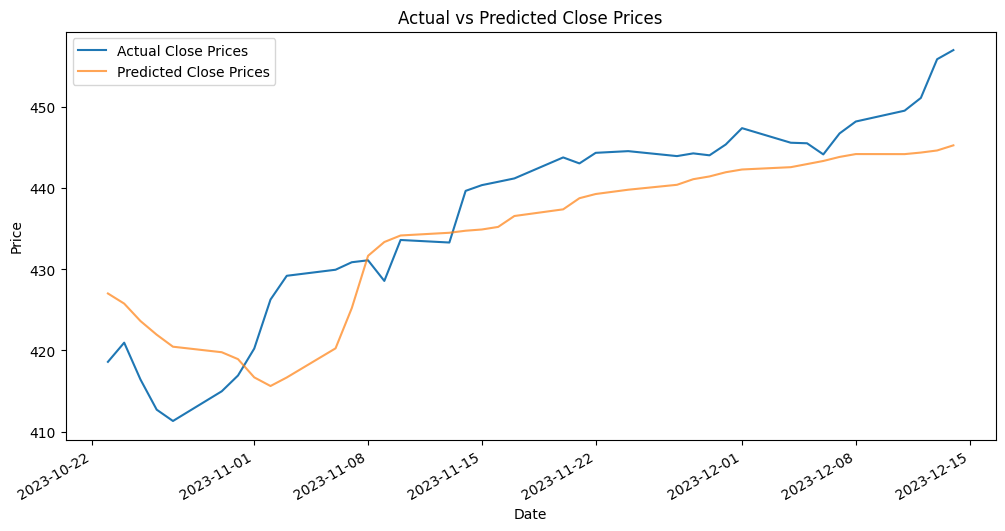

Mean Squared Error: 37.81908878482734
Mean Absolute Error: 5.320306869999788
R2 Score: 0.757542536642084


In [ ]:
# Plot Prediction
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Close Prices')
plt.plot(dates, predictions_rescaled, label='Predicted Close Prices', alpha=0.7)
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

#Calculate Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

## Prediction Data Frame

In [ ]:
# Adjust the slice to match where your test data actually begins.
dates = combined_data.index[-len(y_test_rescaled):]

# Now create a DataFrame with the dates and actual and predicted prices
results_df = pd.DataFrame({
    'Date': dates,
    'Actual Price': y_test_rescaled.flatten(),
    'Predicted Price': predictions_rescaled.flatten()
})

#print
results_df

,Date,Actual Price,Predicted Price
0,2023-10-23,418.593020,427.019462
1,2023-10-24,420.956031,425.772380
2,2023-10-25,416.423827,423.625651
3,2023-10-26,412.696696,421.938223
4,2023-10-27,411.302752,420.458942
5,2023-10-30,414.962798,419.777433
6,2023-10-31,416.908372,418.927319
7,2023-11-01,420.232967,416.678860
8,2023-11-02,426.270924,415.613476
9,2023-11-03,429.200444,416.666577


#Test


# Data Quality Check

In [ ]:
# Check for outliers - this is a simplistic example using standard deviation
outliers = combined_data[np.abs(combined_data - combined_data.mean()) > (3 * combined_data.std())]
combined_data = combined_data[~combined_data.isin(outliers).any(axis=1)]

# Rescale your data if needed
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
combined_data_scaled = scaler.fit_transform(combined_data[features_to_scale])


# Feature Engineering

In [ ]:
# Example of adding a new technical indicator: Relative Strength Index (RSI)
def calculate_rsi(data, window):
    delta = data.diff()
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    gain = up.rolling(window=window).mean()
    loss = down.abs().rolling(window=window).mean()

    RS = gain / loss
    return 100 - (100 / (1 + RS))

combined_data['RSI'] = calculate_rsi(combined_data['Close'], window=14)


<ipython-input-16-222c85ac3291>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_data['RSI'] = calculate_rsi(combined_data['Close'], window=14)


# Model Complexity

In [ ]:
# Simplify model architecture to prevent overfitting
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(sequence_length, len(features_to_scale))))
model.add(Dropout(0.1))
model.add(LSTM(units=32))
model.add(Dropout(0.1))
model.add(Dense(units=1))


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'X' and 'y' are your entire dataset and labels
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

def build_lstm_model(input_shape, units, dropout):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_and_evaluate(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping])
    predicted = model.predict(X_val)
    mse = mean_squared_error(y_val, predicted)
    return mse

# You should define your input_shape, X_train, y_train, X_val, y_val based on your dataset
# input_shape = (sequence_length, num_features)
# X_train, y_train = # your training set
# X_val, y_val = # your validation set

# Example hyperparameter tuning loop
best_mse = float('inf')
best_params = {}

for units in [50, 100, 150]:
    for dropout in [0.1, 0.2, 0.3]:
        model = build_lstm_model(input_shape=(sequence_length, len(features_to_scale)), units=units, dropout=dropout)
        mse = train_and_evaluate(model, X_train, y_train, X_val, y_val)
        print(f"Units: {units}, Dropout: {dropout}, MSE: {mse}")
        if mse < best_mse:
            best_mse = mse
            best_params = {'units': units, 'dropout': dropout}

print(f"Best parameters found: {best_params}")



Epoch 1/50
5/5 [==============================] - 4s 191ms/step - loss: 0.1283 - val_loss: 0.0632
Epoch 2/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0243 - val_loss: 0.0501
Epoch 3/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0350 - val_loss: 0.0320
Epoch 4/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0172 - val_loss: 0.0476
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0184 - val_loss: 0.0446
Epoch 6/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0130 - val_loss: 0.0274
Epoch 7/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0111 - val_loss: 0.0235
Epoch 8/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0105 - val_loss: 0.0225
Epoch 9/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0080 - val_loss: 0.0258
Epoch 10/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0083 - val_loss: 0.0222
Epoch 11/50
5/5 [===========

2/2 [==============================] - 1s 6ms/step
Units: 100, Dropout: 0.1, MSE: 0.01209200194917917
Epoch 1/50
5/5 [==============================] - 4s 185ms/step - loss: 0.1124 - val_loss: 0.0549
Epoch 2/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0584 - val_loss: 0.0327
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0217 - val_loss: 0.0529
Epoch 4/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0254 - val_loss: 0.0340
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0126 - val_loss: 0.0220
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0108 - val_loss: 0.0200
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0077 - val_loss: 0.0174
Epoch 8/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0083 - val_loss: 0.0167
Epoch 9/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0066 - val_loss: 0.0114
Epoch 10/50
5/5 [=======

2/2 [==============================] - 1s 7ms/step
Units: 100, Dropout: 0.2, MSE: 0.009761864005697637
Epoch 1/50
5/5 [==============================] - 5s 359ms/step - loss: 0.1037 - val_loss: 0.0574
Epoch 2/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0517 - val_loss: 0.0273
Epoch 3/50
5/5 [==============================] - 0s 12ms/step - loss: 0.0210 - val_loss: 0.0560
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0238 - val_loss: 0.0318
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0133 - val_loss: 0.0194
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0151 - val_loss: 0.0170
Epoch 7/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0088 - val_loss: 0.0227
Epoch 8/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0095 - val_loss: 0.0148
Epoch 9/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0088 - val_loss: 0.0111
Epoch 10/50
5/5 [======

In [ ]:
# Initialize best_params with default values
best_params = {'units': None, 'dropout': None}

# Example hyperparameter tuning loop
best_mse = float('inf')

for units in [50, 100, 150]:
    for dropout in [0.1, 0.2, 0.3]:
        model = build_lstm_model(input_shape=(sequence_length, len(features_to_scale)), units=units, dropout=dropout)
        mse = train_and_evaluate(model, X_train, y_train, X_val, y_val)
        print(f"Units: {units}, Dropout: {dropout}, MSE: {mse}")
        if mse < best_mse:
            best_mse = mse
            best_params['units'] = units
            best_params['dropout'] = dropout

print(f"Best parameters found: {best_params}")

# Check if the best parameters were found before building the final model
if best_params['units'] is not None and best_params['dropout'] is not None:
    final_model = build_lstm_model(input_shape=(sequence_length, len(features_to_scale)),
                                   units=best_params['units'],
                                   dropout=best_params['dropout'])
else:
    print("Best parameters were not found. Check the hyperparameter tuning process.")


Epoch 1/50
5/5 [==============================] - 5s 191ms/step - loss: 0.1905 - val_loss: 0.1209
Epoch 2/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0348 - val_loss: 0.0321
Epoch 3/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0334 - val_loss: 0.0413
Epoch 4/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0229 - val_loss: 0.0262
Epoch 5/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0161 - val_loss: 0.0338
Epoch 6/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0168 - val_loss: 0.0319
Epoch 7/50
5/5 [==============================] - 0s 14ms/step - loss: 0.0118 - val_loss: 0.0227
Epoch 8/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0094 - val_loss: 0.0198
Epoch 9/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0097 - val_loss: 0.0180
Epoch 10/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0088 - val_loss: 0.0178
Epoch 11/50
5/5 [===========

Epoch 1/50
6/6 [==============================] - 3s 6ms/step - loss: 0.1775
Epoch 2/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0422
Epoch 3/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0390
Epoch 4/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0247
Epoch 5/50
6/6 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 6/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 7/50
6/6 [==============================] - 0s 7ms/step - loss: 0.0155
Epoch 8/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0146
Epoch 9/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 10/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0110
Epoch 11/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0107
Epoch 12/50
6/6 [==============================] - 0s 6ms/step - loss: 0.0093
Epoch 13/50
6/6 [==============================] - 0s 6ms/step - loss: 0.

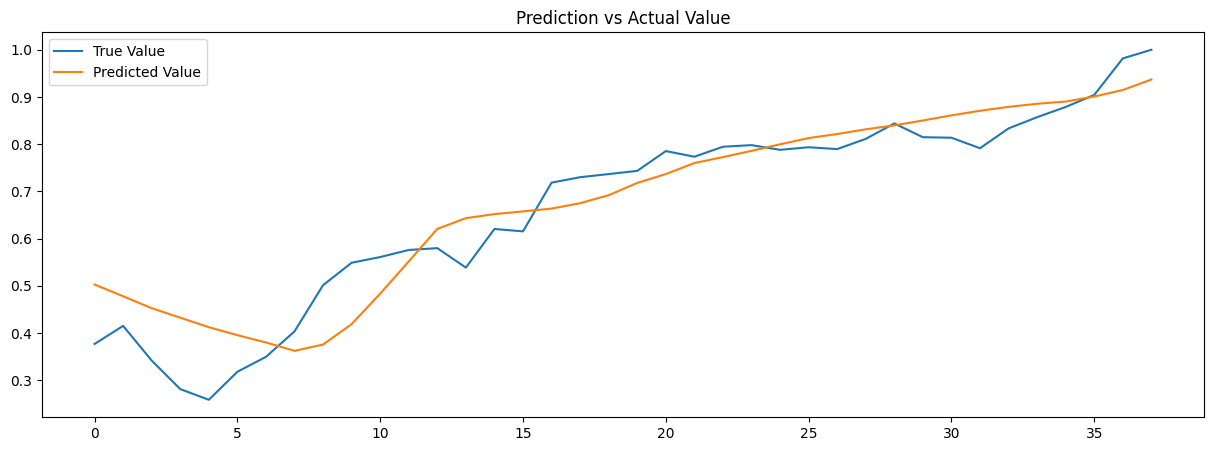

Test MSE: 0.004659406208603155
Test MAE: 0.05460414113930601
Test R2 Score: 0.8863967941399583


In [ ]:
# Using the best parameters from the hyperparameter tuning to build the final model
final_model = build_lstm_model(input_shape=(sequence_length, len(features_to_scale)),
                               units=50,  # This is the 'units' value from the best_params
                               dropout=0.2)  # This is the 'dropout' value from the best_params

# Train the final model with the full dataset or combined training and validation sets
# If you want to include the validation set in training because you won't be using it anymore
X_full_train = np.concatenate((X_train, X_val))
y_full_train = np.concatenate((y_train, y_val))

# Train the model
final_model.fit(X_full_train, y_full_train, epochs=50, batch_size=32, verbose=1)

# After training, evaluate your model on the test set if you have one
predicted_test = final_model.predict(X_test)
test_mse = mean_squared_error(y_test, predicted_test)
print(f"Test MSE: {test_mse}")

# Optionally, plot the predictions against the actual values
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='True Value')
plt.plot(predicted_test, label='Predicted Value')
plt.title('Prediction vs Actual Value')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate MSE
test_mse = mean_squared_error(y_test, predicted_test)
print(f"Test MSE: {test_mse}")

# Calculate MAE
test_mae = mean_absolute_error(y_test, predicted_test)
print(f"Test MAE: {test_mae}")

# Calculate R2 Score
test_r2 = r2_score(y_test, predicted_test)
print(f"Test R2 Score: {test_r2}")
